Built on top of [BindDiffusion](https://github.com/sail-sg/BindDiffusion/blob/main/audio2image.ipynb)

In [24]:
""" importing modules
"""
import torch
from PIL import Image
import numpy as np
import os
from omegaconf import OmegaConf
from easydict import EasyDict
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import image_bind.data as data
from image_bind.models import imagebind_model
from image_bind.models.imagebind_model import ModalityType

from ldm.models.diffusion.ddpm import ImageEmbeddingConditionedLatentDiffusion
from ldm.models.diffusion.ddim import DDIMSampler

### 1. Define ImageBind model

In [2]:
class Binder:
    """ Wrapper for ImageBind model
    """
    def __init__(self, pth_path, device='cuda'):
        self.model = imagebind_model.imagebind_huge(pretrained=True)
        self.device = device
        self.model.eval()
        self.model.to(device)

        self.data_process_dict = {ModalityType.TEXT: data.load_and_transform_text,
                                  ModalityType.VISION: data.load_and_transform_vision_data,
                                  ModalityType.AUDIO: data.load_and_transform_audio_data}

    def run(self, ctype, cpaths, post_process=False):
        """ ctype: str
            cpaths: list[str]
        """
        inputs = {ctype: self.data_process_dict[ctype](cpaths, self.device)}
        with torch.no_grad():
            embeddings = self.model(inputs)

        return embeddings[ctype]

device = 'cpu'
binder = Binder(pth_path="/home/eugene/models/converted/imagebind/imagebind_huge.pth", device=device)

### 2. Define Diffusion model

In [3]:
# options
opt = EasyDict(config = './configs/stable-diffusion/v2-1-stable-unclip-h-bind-inference.yaml',
               device = 'cuda',
               ckpt = './checkpoints/stable-diffusion-2-1-unclip/sd21-unclip-h.ckpt',
               C = 4,
               H = 768,
               W = 768,
               f = 8,
               steps = 50, 
               n_samples = 1,
               scale = 20,
               ddim_eta = 0,
                torch_dtype=torch.float16
               )

config = OmegaConf.load(f"{opt.config}")
shape = [opt.C, opt.H // opt.f, opt.W // opt.f]
batch_size = opt.n_samples

# prepare diffusion model
model = ImageEmbeddingConditionedLatentDiffusion(**config.model['params'])
pl_sd = torch.load(opt.ckpt, map_location="cpu")
sd = pl_sd["state_dict"]
model.load_state_dict(sd, strict=False)
model= model.half()
model.to(opt.device)
model.eval()

sampler = DDIMSampler(model, device=opt.device)

ImageEmbeddingConditionedLatentDiffusion: Running in v-prediction mode
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 5 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 1024 and using 5 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 5 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 1024 and using 5 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 10 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 1024 and using 10 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 10 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 1024 and using 10 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, context_dim is None and using 20 heads.
Setting up MemoryEfficientCrossA

In [4]:
def load_img(path):
    image = Image.open(path).convert("RGB")
    w, h = image.size
    print(f"loaded input image of size ({w}, {h}) from {path}")
    w, h = map(lambda x: x - x % 64, (w, h))  # resize to integer multiple of 64
    image = image.resize((w, h), resample=Image.LANCZOS)
    image = np.array(image).astype(np.float32) / 255.0
    image = image[None].transpose(0, 3, 1, 2)
    image = torch.from_numpy(image)
    return 2. * image - 1.

### 3. Conditioned image generation

In [202]:
def paudio(audio):
    if '.pt' in audio:
        inputs = {'audio': torch.load(audio).cpu()}
    else:
        inputs = {'audio': data.load_and_transform_audio_data([audio], 'cpu')}
        

    with torch.no_grad():
        embeddings = binder.model(inputs)
    prompts = ['cartoon, colorful, animated, clear, vivid'] * batch_size    # you may add extra descriptions you like here
    # c_adm = binder.run(ctype='audio', cpaths=['assets/bird_audio.wav'])
    c_adm = embeddings['audio']
    c_adm = c_adm / c_adm.norm() * 20   # a norm of 20 typically gives better result 
    c_adm = torch.cat([c_adm] * batch_size, dim=0)
    c_adm = c_adm.half().to('cuda:0')
    n_prompt = 'longbody, lowres, bad anatomy, bad hands, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality'

    
    with torch.no_grad(), torch.autocast('cuda'):
        
        c_adm, noise_level_emb = model.noise_augmentor(c_adm, noise_level=torch.zeros(batch_size).long().to(c_adm.device))
        c_adm = torch.cat((c_adm, noise_level_emb), 1)
    
        uc = model.get_learned_conditioning(batch_size * [n_prompt])    # negative prompts
        uc = {"c_crossattn": [uc], "c_adm": torch.zeros_like(c_adm)}
        c = {"c_crossattn": [model.get_learned_conditioning(prompts)], "c_adm": c_adm}
        
        samples, _ = sampler.sample(S=opt.steps,
                                    conditioning=c,
                                    batch_size=batch_size,
                                    shape=shape,
                                    verbose=False,
                                    unconditional_guidance_scale=opt.scale,
                                    unconditional_conditioning=uc,
                                    eta=opt.ddim_eta,
                                    x_T=None)
    
    x_samples = model.decode_first_stage(samples.half())
    x_samples = torch.clamp((x_samples + 1.0) / 2.0, min=0.0, max=1.0)
    plt.imshow(x_samples[0].permute(1,2,0).cpu().float().numpy())


def pimage(path):
    if '.pt' in path:
        inputs = {'vision': torch.load(path).cpu()}
    else:
        inputs = {'vision': data.load_and_transform_vision_data([path], 'cpu')}
        
    with torch.no_grad():
        embeddings = binder.model(inputs)
    prompts = ['cartoon, colorful, animated, clear, vivid'] * batch_size    # you may add extra descriptions you like here
    # prompts = [''] * batch_size    # you may add extra descriptions you like here

    # c_adm = binder.run(ctype='audio', cpaths=['assets/bird_audio.wav'])
    c_adm = embeddings['vision']
    c_adm = c_adm / c_adm.norm() * 20   # a norm of 20 typically gives better result 
    c_adm = torch.cat([c_adm] * batch_size, dim=0)
    n_prompt = 'longbody, lowres, bad anatomy, bad hands, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality'
    
    c_adm = c_adm.half().to('cuda:0')
    
    # c_adm = 18.5066 * c_adm/c_adm.norm()
    
    with torch.no_grad(), torch.autocast('cuda'):
        
        c_adm, noise_level_emb = model.noise_augmentor(c_adm, noise_level=torch.zeros(batch_size).long().to(c_adm.device))
        c_adm = torch.cat((c_adm, noise_level_emb), 1)
    
        uc = model.get_learned_conditioning(batch_size * n_prompt)    # negative prompts
        uc = {"c_crossattn": [uc], "c_adm": torch.zeros_like(c_adm)}
        c = {"c_crossattn": [model.get_learned_conditioning(prompts)], "c_adm": c_adm}
        scale = opt.scale
        scale = 20
        samples, _ = sampler.sample(S=opt.steps,
                                    conditioning=c,
                                    batch_size=batch_size,
                                    shape=shape,
                                    verbose=False,
                                    unconditional_guidance_scale=scale,
                                    unconditional_conditioning=uc,
                                    eta=opt.ddim_eta,
                                    x_T=None)
    
    x_samples = model.decode_first_stage(samples.half())
    x_samples = torch.clamp((x_samples + 1.0) / 2.0, min=0.0, max=1.0)
    plt.imshow(x_samples[0].permute(1,2,0).cpu().float().numpy())
    

def on_embed(c_adm):
    prompts = ['cartoon, colorful, animated, clear, vivid'] * batch_size    # you may add extra descriptions you like here
    # c_adm = binder.run(ctype='audio', cpaths=['assets/bird_audio.wav'])
    
    c_adm = c_adm / c_adm.norm() * 20   # a norm of 20 typically gives better result 
    c_adm = torch.cat([c_adm] * batch_size, dim=0)
    n_prompt = 'longbody, lowres, bad anatomy, bad hands, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality'
    
    c_adm = c_adm.half().to('cuda:0')
        
    with torch.no_grad(), torch.autocast('cuda'):
        
        c_adm, noise_level_emb = model.noise_augmentor(c_adm, noise_level=torch.zeros(batch_size).long().to(c_adm.device))
        c_adm = torch.cat((c_adm, noise_level_emb), 1)
    
        uc = model.get_learned_conditioning(batch_size * n_prompt)    # negative prompts
        uc = {"c_crossattn": [uc], "c_adm": torch.zeros_like(c_adm)}
        c = {"c_crossattn": [model.get_learned_conditioning(prompts)], "c_adm": c_adm}
        
        samples, _ = sampler.sample(S=opt.steps,
                                    conditioning=c,
                                    batch_size=batch_size,
                                    shape=shape,
                                    verbose=False,
                                    unconditional_guidance_scale=opt.scale,
                                    unconditional_conditioning=uc,
                                    eta=opt.ddim_eta,
                                    x_T=None)
    
    x_samples = model.decode_first_stage(samples.half())
    x_samples = torch.clamp((x_samples + 1.0) / 2.0, min=0.0, max=1.0)
    plt.imshow(x_samples[0].permute(1,2,0).cpu().float().numpy())

In [342]:
def from_text(text):
    
    inputs = {'text': data.load_and_transform_text([text], device)}
        
    with torch.no_grad():
        embeddings = binder.model(inputs)
    prompts = ['cartoon, colorful, animated, clear, vivid'] * batch_size    # you may add extra descriptions you like here
    # prompts = [''] * batch_size    # you may add extra descriptions you like here

    # c_adm = binder.run(ctype='audio', cpaths=['assets/bird_audio.wav'])
    c_adm = embeddings['text']
    c_adm = c_adm / c_adm.norm() * 20   # a norm of 20 typically gives better result 
    c_adm = torch.cat([c_adm] * batch_size, dim=0)
    n_prompt = 'longbody, lowres, bad anatomy, bad hands, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality'
    
    c_adm = c_adm.half().to('cuda:0')
    
    # c_adm = 18.5066 * c_adm/c_adm.norm()
    
    with torch.no_grad(), torch.autocast('cuda'):
        
        c_adm, noise_level_emb = model.noise_augmentor(c_adm, noise_level=torch.zeros(batch_size).long().to(c_adm.device))
        c_adm = torch.cat((c_adm, noise_level_emb), 1)
    
        uc = model.get_learned_conditioning(batch_size * n_prompt)    # negative prompts
        uc = {"c_crossattn": [uc], "c_adm": torch.zeros_like(c_adm)}
        c = {"c_crossattn": [model.get_learned_conditioning(prompts)], "c_adm": c_adm}
        scale = opt.scale
        scale = 20
        samples, _ = sampler.sample(S=opt.steps,
                                    conditioning=c,
                                    batch_size=batch_size,
                                    shape=shape,
                                    verbose=False,
                                    unconditional_guidance_scale=scale,
                                    unconditional_conditioning=uc,
                                    eta=opt.ddim_eta,
                                    x_T=None)
    
    x_samples = model.decode_first_stage(samples.half())
    x_samples = torch.clamp((x_samples + 1.0) / 2.0, min=0.0, max=1.0)
    plt.imshow(x_samples[0].permute(1,2,0).cpu().float().numpy())

Data shape for DDIM sampling is (1, 4, 96, 96), eta 0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  6.20it/s]


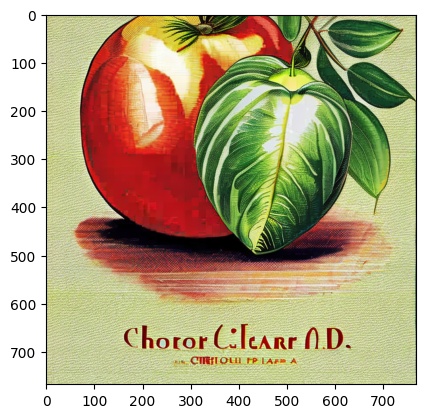

In [414]:
pimage('./all_assets/magritte_apple_sq3.png')

Data shape for DDIM sampling is (1, 4, 96, 96), eta 0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.29it/s]


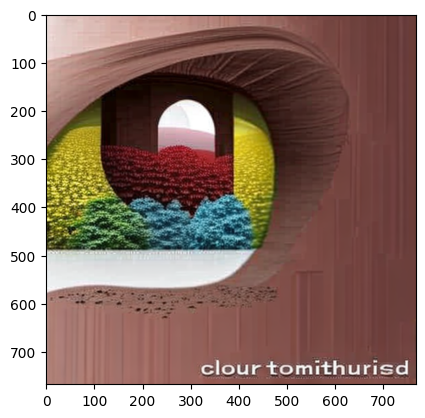

In [418]:
pimage('./hack/image_apple_eye.pt')

Data shape for DDIM sampling is (1, 4, 96, 96), eta 0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  6.15it/s]


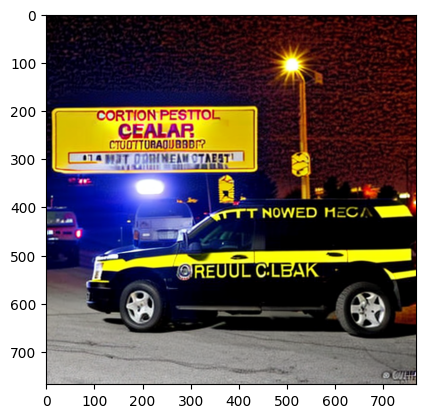

In [131]:
paudio('./all_assets/police3.wav')

Data shape for DDIM sampling is (1, 4, 96, 96), eta 0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.27it/s]


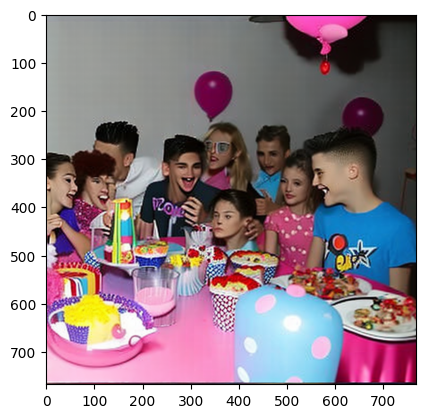

In [132]:
plot_it('./hack/police_to_party2.pt')